In [1]:
from PIL import Image
import nibabel
import os, pathlib, numpy, json
import h5py
from fenics import *
from fenics_adjoint import *

In [2]:
datadir = pathlib.Path("/home/bastian/Oscar-Image-Registration-via-Transport-Equation/testdata_3d")

In [3]:
datadir = pathlib.Path("/home/bastian/Oscar-Image-Registration-via-Transport-Equation/testdata_2d")

In [4]:
hyperparameters = {}
hyperparameters["state_functiondegree"] = 1
hyperparameters["state_functionspace"] = "DG"

In [5]:
hyperparameters["normalize"] = True

In [6]:
hyperparameters["image"] = str(datadir / "input.mgz")

In [7]:
from mri_utils.MRI2FEM import read_image

In [8]:
def Pic2FEM(FName, mesh=None, color=False, normalize=True):
    if FName.endswith("mgz"):
        import nibabel
        myarray=nibabel.load(FName).get_fdata()[:,:, 0]
        myarray = myarray / np.max(myarray)
        img = Image.fromarray(np.uint8(myarray*255))
        img = img.convert("RGB")
    else:
        img = Image.open(FName)
    xPixel = np.shape(img)[0]
    yPixel = np.shape(img)[1]
    
    #which of the color channels to process
    if color:
        Channels = (0,1,2)
        img.convert("RGB")
    else:
        Channels = (0,)
        img.convert("L")        
    
    if mesh == None:
        mesh = RectangleMesh(MPI.comm_world, Point(0.0, 0.0), Point(img.size[0], img.size[1]), int(img.size[0]), int(img.size[1]), "right")
    
    #Key mapping between global vertex index (input) and (i,j) pixel coordinate (output)
    #needs to be changed if the diagonal is not "right"
    PixID = np.zeros([2*img.size[0]*img.size[1], 2], dtype="uint")
    for i in range(img.size[0]):
        for j in range(img.size[1]):
            #print "init:", i, j
            PixID[2*(img.size[0]*j + i)+0, 0] = img.size[1] - 1 - j
            PixID[2*(img.size[0]*j + i)+1, 0] = img.size[1] - 1 - j
            PixID[2*(img.size[0]*j + i)+0, 1] = i
            PixID[2*(img.size[0]*j + i)+1, 1] = i
    
    if color:
        ImgSpace = VectorFunctionSpace(mesh, "DG", 0, len(Channels))
    else:
        ImgSpace = FunctionSpace(mesh, "DG", 0)
        
    ImgFunction = Function(ImgSpace)
    ImgFunction.rename("image", "")
    Fvalues = np.zeros(ImgFunction.vector().local_size())
        
    for chan in Channels:
        if color:
            ImgDofs = ImgSpace.sub(chan).dofmap()
            cData = np.array(img.getchannel(chan))
        else:
            ImgDofs = ImgSpace.dofmap() #tabulate_dof_coordinates()
            cData = np.array(img.getchannel(chan))
        
        for c in cells(mesh):
            #local and global index of cell
            LID = c.index()
            GID = c.global_index()
            #local dof in DG0 function
            FID = ImgDofs.cell_dofs(c.index())[0]
            #get grey value from image
            MyGrey = cData[PixID[GID, 0], PixID[GID, 1]]
            #map 0..255 grey steps to [0,1]
            normval = 1
            if normalize:
                normval = 255.0
            fValue = MyGrey/(normval)
            Fvalues[FID] = fValue

    #Set function values
    ImgFunction.vector().set_local(Fvalues)
    ImgFunction.vector().apply("")


    Space = FunctionSpace(mesh, hyperparameters["state_functionspace"], hyperparameters["state_functiondegree"])
    ImgFunction = project(sqrt(inner(ImgFunction, ImgFunction)), Space)
        
    return mesh, ImgFunction, len(Channels)

In [9]:
FName2 = str(hyperparameters["image"])

rawF = nibabel.load(FName2).get_fdata()

if hyperparameters["normalize"]:
    rawF /= np.max(rawF)

    rawF = np.where(rawF < 0, 0, rawF)

In [42]:
mymesh, my_img, channels = read_image(hyperparameters, name="image", mesh=None, printout=True, 
                                      normalize=hyperparameters["normalize"])

Loading /home/bastian/Oscar-Image-Registration-via-Transport-Equation/testdata_2d/input.mgz
dimension of image: (16, 22, 1) ( 352 voxels)
Normalizing image
Img.vector()[:].max() 0.9367520809173584
Applying ReLU() to image


In [43]:
fenmesh, fen_img1, fenchannels = Pic2FEM(FName=hyperparameters["image"], 
                                         color=False, normalize=hyperparameters["normalize"],
                                         mesh=None)#hyperparameters["state_functiondegree"])

In [46]:
print(len(mymesh.coordinates()))
print(len(fenmesh.coordinates()))

print(my_img.vector()[:].shape)
print(fen_img1.vector()[:].shape)

391
391
(2112,)
(2112,)


In [12]:
Space = FunctionSpace(fenmesh, hyperparameters["state_functionspace"], 
                      0
                      #hyperparameters["state_functiondegree"]
                     )
fen_img = project(fen_img1, Space)

In [13]:
print(np.mean(rawF))

print(assemble(fen_img1*dx(domain=fenmesh)) / assemble(1*dx(domain=fenmesh)))
print(assemble(fen_img*dx(domain=fenmesh)) / assemble(1*dx(domain=fenmesh)))
print(assemble(my_img*dx(domain=mymesh)) / assemble(1*dx(domain=mymesh)))


0.09704711909028453
0.09639037433155086
0.09639037433155086
0.09718642814074238


In [14]:
rawF.size

352

In [15]:
rawF.shape

(16, 22, 1)

In [16]:
nx, ny = rawF.shape[0], rawF.shape[1]

dn = 1

mesh2 = UnitSquareMesh(MPI.comm_world, nx - dn, ny - dn)

V = FunctionSpace(mesh2, "DG", 1)

print(np.unique(V.tabulate_dof_coordinates(), axis=0).shape)
print(np.unique(V.tabulate_dof_coordinates(), axis=1).shape)

(352, 2)
(1890, 2)


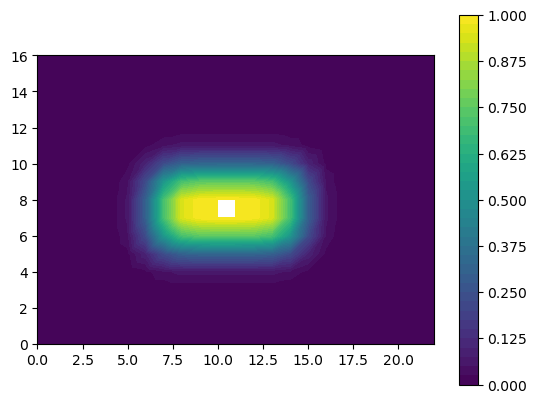

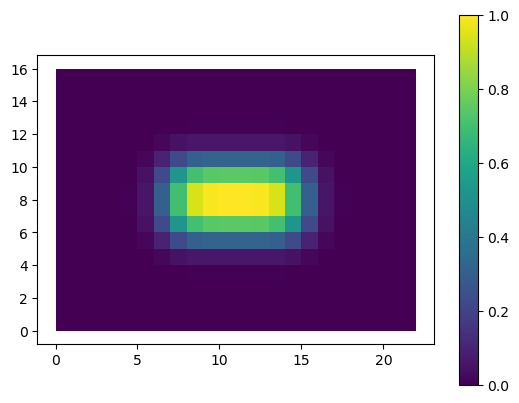

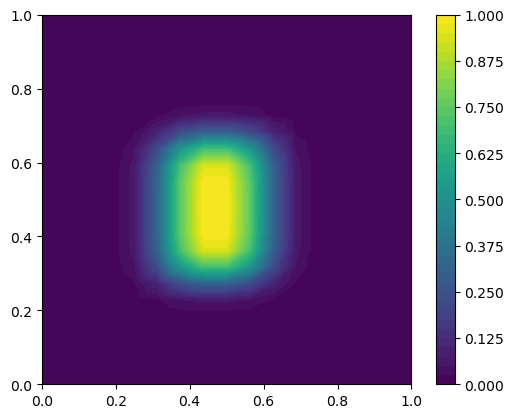

'\nfor x in range(nx):\n    for y in range(ny):\n        ax1.set_title("image[x,y]")\n        ax1.scatter(y,x, c=my_img[x,y], \n                    cmap="viridis", vmin=0, vmax=1,\n                    s=240, marker="s")\nfor ax in [ax1]:\n    ax.invert_yaxis()\n    ax.set_aspect(1)\nplt.colorbar()\nplt.show()\n'

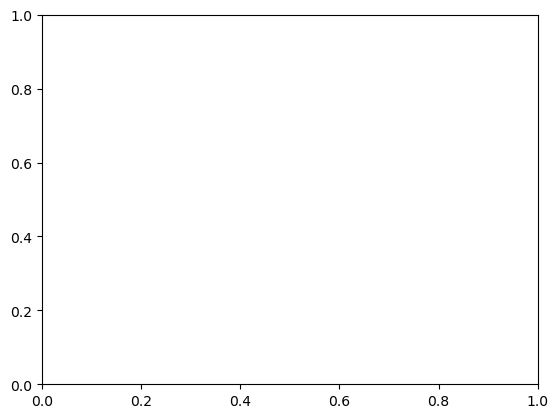

In [17]:
ax = plot(fen_img1)
plt.colorbar(ax)
plt.show()
ax = plot(fen_img)
plt.colorbar(ax)
plt.show()
ax = plot(my_img)
plt.colorbar(ax)
plt.show()
fig, ax1 = plt.subplots(1)

"""
for x in range(nx):
    for y in range(ny):
        ax1.set_title("image[x,y]")
        ax1.scatter(y,x, c=my_img[x,y], 
                    cmap="viridis", vmin=0, vmax=1,
                    s=240, marker="s")
for ax in [ax1]:
    ax.invert_yaxis()
    ax.set_aspect(1)
plt.colorbar()
plt.show()
"""


In [18]:
image = nibabel.load(FName2).get_fdata()

In [19]:
nx, ny = image.shape[0], image.shape[1]

mesh2 = UnitSquareMesh(MPI.comm_world, nx, ny)

VDG0=FunctionSpace(mesh2, "DG", 0)
VDG1=FunctionSpace(mesh2, "DG", 1)
u0=Function(VDG0)
u1=Function(VDG1)

In [20]:
image.size

352

In [21]:
u0.vector()[:].shape

(704,)

In [22]:
u1.vector()[:].shape

(2112,)

In [23]:
(rawF.shape[0]+1)*(rawF.shape[1]+1)

391

In [24]:
VDG0.tabulate_dof_coordinates().shape

(704, 2)

In [25]:
VDG1.tabulate_dof_coordinates().shape

(2112, 2)

In [26]:
np.unique(VDG0.tabulate_dof_coordinates(), axis=0).shape

(704, 2)

In [27]:
np.unique(VDG0.tabulate_dof_coordinates(), axis=1).shape

(704, 2)

In [28]:
np.unique(VDG1.tabulate_dof_coordinates(), axis=0).shape

(391, 2)

In [29]:
np.unique(VDG1.tabulate_dof_coordinates(), axis=1).shape

(2112, 2)

In [30]:
VDG1.tabulate_dof_coordinates().shape

(2112, 2)

In [31]:
xy = my_img.function_space().tabulate_dof_coordinates()

In [32]:
xy.shape

(2112, 2)

In [33]:
image.shape[0]*image.shape[1]

352

In [34]:
newimg = np.zeros_like(image) + np.nan
for x in range(nx):
    for y in range(ny):
        newimg[x,y] = u0(x/(nx-1),y/(ny-1))
        # newimg[x,y] = x/(nx-1)*y/(ny-1)
        
assert np.sum(np.isnan(newimg)) == 0

In [35]:
print(np.max(newimg))

0.0


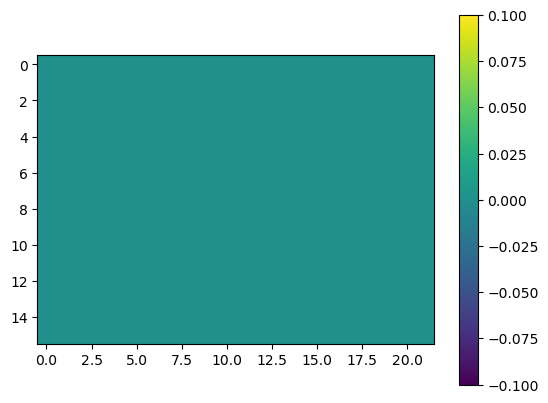

In [36]:
plt.imshow(newimg)
plt.colorbar()

In [37]:
nx, ny = image.shape[0], image.shape[1]

dn = 0

mesh2 = UnitSquareMesh(MPI.comm_world, nx - dn, ny - dn)

VDG0=FunctionSpace(mesh2, "DG", 0)
VDG1=FunctionSpace(mesh2, "DG", 1)
u0=Function(VDG0)

u1 = Function(VDG1)

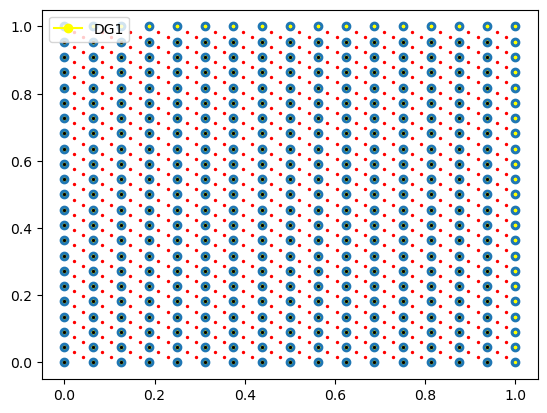

In [38]:
plt.scatter(mesh2.coordinates()[:,0], mesh2.coordinates()[:,1])

xy = u0.function_space().tabulate_dof_coordinates()
plt.scatter(xy[:,0], xy[:,1], c="r", s=2)

xy = u1.function_space().tabulate_dof_coordinates()
plt.scatter(xy[:,0], xy[:,1], c="yellow", s=2)

for x in range(nx):
    for y in range(ny):
        plt.scatter(x/nx, y/ny, s=2, c="k")
        
        
plt.plot([],[], marker="o", label="DG1", color="yellow")
plt.legend()
#for cell in cells(mesh2):
#    plt.scatter(x=cell.midpoint()[:][0],y=cell.midpoint()[:][1], c="navy")

In [39]:
do_norm = True

In [40]:
if do_norm:
    image2 = np.copy(image)
    image2 /= np.max(image2)

    image2 = np.where(image2 < 0, 0, image2)
    
else:
    image2 = np.copy(image)

In [41]:
_, my_img, _ = read_image(hyperparameters, name="image", 
                                      mesh=None, printout=True, normalize=do_norm)
_, my_img1, _ = read_image(hyperparameters, name="image", degree=1,
                                      mesh=None, printout=True, normalize=do_norm)

_, fen_img0, _ = Pic2FEM(FName=hyperparameters["image"], 
                                         color=True, normalize=do_norm,
                                         mesh=None)#hyperparameters["state_functiondegree"])

_, fen_img1, _ = Pic2FEM(FName=hyperparameters["image"], 
                                         color=False, normalize=do_norm,
                                         mesh=None)#hyperparameters["state_functiondegree"])

Loading /home/bastian/Oscar-Image-Registration-via-Transport-Equation/testdata_2d/input.mgz
dimension of image: (16, 22, 1) ( 352 voxels)
Normalizing image
Img.vector()[:].max() 0.9367520809173584
Applying ReLU() to image


TypeError: read_image() got an unexpected keyword argument 'degree'

In [ ]:
print(np.mean(image2))

print(assemble(fen_img1*dx(domain=fenmesh)) / assemble(1*dx(domain=fenmesh)))
print(assemble(fen_img0*dx(domain=fenmesh)) / assemble(1*dx(domain=fenmesh)))
print(assemble(my_img*dx(domain=mymesh)) / assemble(1*dx(domain=mymesh)))
print(assemble(my_img1*dx(domain=mymesh1)) / assemble(1*dx(domain=mymesh1)))

In [ ]:
ax = plot(my_img)
plt.colorbar(ax)
plt.show()
ax = plot(my_img1)
plt.colorbar(ax)
plt.show()
ax = plot(fen_img0)
plt.colorbar(ax)
plt.show()
ax = plot(fen_img1)
plt.colorbar(ax)
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1)
fig2, ax2 = plt.subplots(1)
fig3, ax3 = plt.subplots(1)
fig4, ax4 = plt.subplots(1)
fig5, ax5 = plt.subplots(1)

for x in range(nx):
    for y in range(ny):
        ax1.set_title("image[x,y]")
        ax1.scatter(y,x, c=image[x,y], 
                    cmap="viridis", vmin=0, vmax=1,
                    s=240, marker="s")
        
        ax2.set_title("my_img(x/nx,y/ny)")
        ax2.scatter(y,x, c=my_img(x/nx,y/ny), 
                    cmap="viridis", vmin=0, vmax=1,
                    s=240, marker="s")
        
        ax3.set_title("my_img1(x/nx,y/ny)")
        ax3.scatter(y,x, c=my_img1(x/nx,y/ny), 
                    cmap="viridis", vmin=0, vmax=1,
                    s=240, marker="s")
        ax4.set_title("fen_img0(y, x)")
        ax4.scatter(y,x, c=fen_img0(y,x), 
                    cmap="viridis", vmin=0, vmax=1,
                    s=240, marker="s")
        ax5.set_title("fen_img1(y, x)")
        ax5.scatter(y,x, c=fen_img1(y,x), 
                    cmap="viridis", vmin=0, vmax=1,
                    s=240, marker="s")
        
for ax in [ax1, ax2, ax3, ax4, ax5]:
    # ax = plt.gca()
    ax.invert_yaxis()
    ax.set_aspect(1)
#plt.colorbar()
plt.show()

plt.title("imshow image")
plt.imshow(image2, vmin=0, vmax=1)
#plt.colorbar()
plt.show()